## Table of contents
1. [Introduction](#intro)
2. [Linear regression using numerical features](#linregnum)
3. [Regularized regressions using numerical features](#reglinregnum)
4. [Linear regression + categorical encoding](#linregcat)
5. [Random Forest](#randomforest)
6. [XGBoost](#xgb)
7. [What's next](#next)


### Introduction <a name='intro'>
In this post, I want produce some simple predictions on the [February Tabular PLayground Series](https://www.kaggle.com/c/tabular-playground-series-feb-2021) without feature selection, and see how far we can go by applying different models. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/train.csv",index_col=0)
test = pd.read_csv("data/test.csv",index_col=0)

In [3]:
y = pd.DataFrame(df.target)
train = df.drop(['target'],axis=1)
categorical = train.columns[0:10]
numerical = train.columns[10:]

We have the following helper function. 

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    if axes is None:
        axes = plt.axes()

    plt.title(title)
    
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                        scoring = "neg_root_mean_squared_error",
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

### Linear regression using numerical columns <a name='linregnum'>

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, learning_curve, \
                                    validation_curve

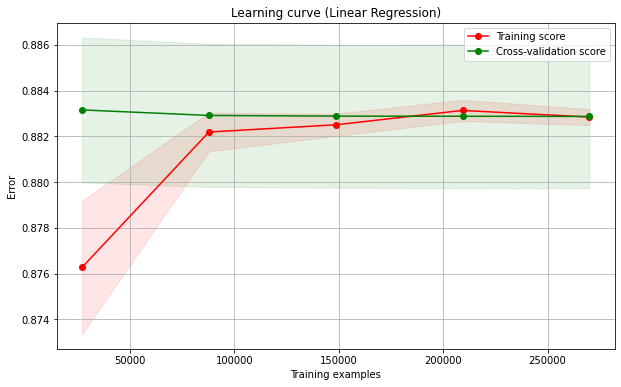

In [9]:
# Learning curve for linear regression
title = "Learning curve (Linear Regression)"
plot_learning_curve(LinearRegression(),title,train[numerical],
                    y,cv=10)
plt.show()

The learning curve plot does not suggest any overfitting since the training and cross-validation scores are quite close. But, there seems to be some underfitting. 

In [26]:
linreg_preds=LinearRegression().fit(train[numerical],y).predict(test[numerical])
linreg_preds = pd.DataFrame(linreg_preds,index=test.index)
linreg_preds.columns = ['target']
linreg_preds.to_csv('predictions/linreg.csv')

In [27]:
linreg_preds

,target
id,
0,7.377975
5,7.637387
15,7.409301
16,7.347044
17,7.402252
...,...
499987,7.385944
499990,7.438991
499991,7.584926


### Regularized regressions <a name='reglinregnum'>

In the learning curve plot, the errors from training and cross-validation are quite, and so do not suggest an overfitting problem. Thus, it is not likely that regularization would help. However, we will still try it here. 

#### Ridge regression

In [25]:
from sklearn.linear_model import RidgeCV, Ridge

In [26]:
alphas = [0.0001,0.0003,0.001,0.003,0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

ridgecv = RidgeCV(alphas=alphas,cv=10).fit(train[numerical],y)
ridgecv.score(train[numerical],y), ridgecv.alpha_

(0.00999972778473579, 10.0)

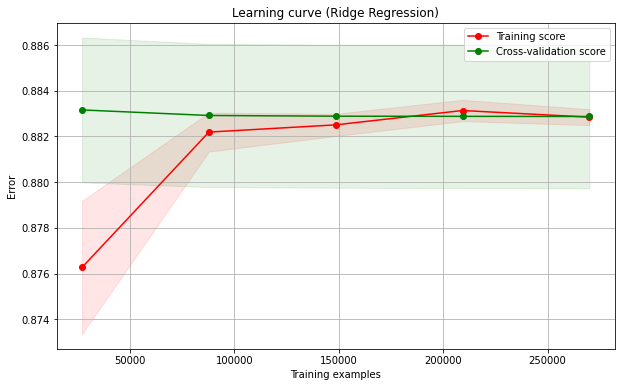

In [27]:
# Learning curve for Ridge regression
title = "Learning curve (Ridge Regression)"
plot_learning_curve(Ridge(alpha=10),title,train[numerical],
                    y,cv=10)
plt.show()

#### Lasso

In [28]:
from sklearn.linear_model import Lasso, LassoCV

In [29]:
alphas = [0.0001,0.0003,0.001,0.003,0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

lassocv = LassoCV(alphas=alphas,cv=10).fit(train[numerical],y)
lassocv.score(train[numerical],y), lassocv.alpha_

d:\projects\funwithkaggle\venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.009993179955551046, 0.0001)

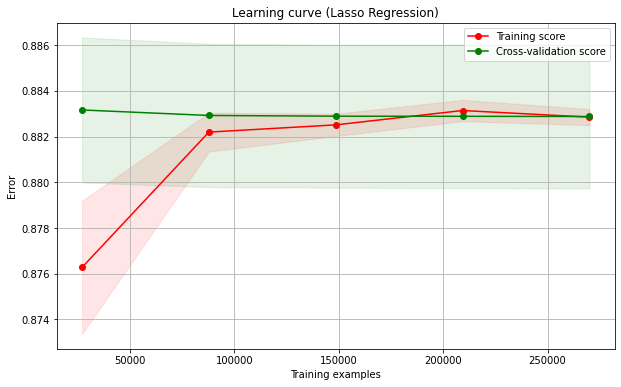

In [33]:
# Learning curve for Lasso regression
title = "Learning curve (Lasso Regression)"
plot_learning_curve(Lasso(alpha=0.0001),title,train[numerical],
                    y,cv=10)
plt.show()

In either case, it seems that regularization was not quite helpful. 

### Linear regression + categorical encodings <a name='linregcat'>
#### Label encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

In [40]:
le = LabelEncoder()

le_train = train.copy()
le_test = test.copy()

for col in categorical:
    le_train[col] = le.fit_transform(train[col])
    le_test[col] = le.transform(test[col])

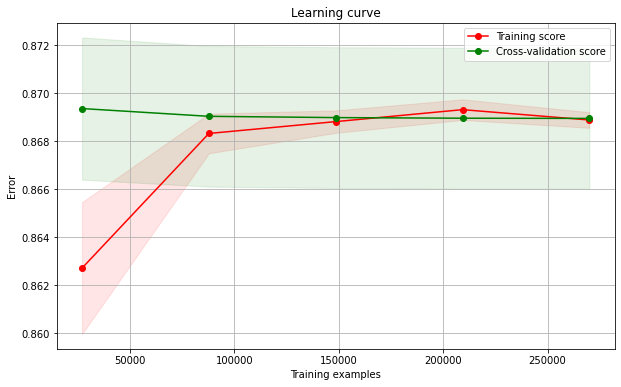

In [41]:
# Learning curve for linear regression
title = "Learning curve"
plot_learning_curve(LinearRegression(),title,le_train,
                    y,cv=10)
plt.show()

In [42]:
linregle_preds=LinearRegression().fit(le_train,y).predict(le_test)
linregle_preds = pd.DataFrame(linregle_preds,index=test.index)
linregle_preds.columns = ['target']
linregle_preds.to_csv('predictions/linregle.csv')

In [43]:
linregle_preds

,target
id,
0,7.479715
5,7.820140
15,7.597872
16,7.431729
17,7.423537
...,...
499987,7.243416
499990,7.317814
499991,7.560099


#### One-hot encoding

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
oh = OneHotEncoder(handle_unknown='ignore',sparse=False)
oh_train = pd.DataFrame(oh.fit_transform(train[categorical]))
oh_test = pd.DataFrame(oh.transform(test[categorical]))
oh_train.index = train.index
oh_test.index = test.index

In [12]:
train_encoded = pd.concat([oh_train,train[numerical]],axis=1)
test_encoded = pd.concat([oh_test,test[numerical]],axis=1)

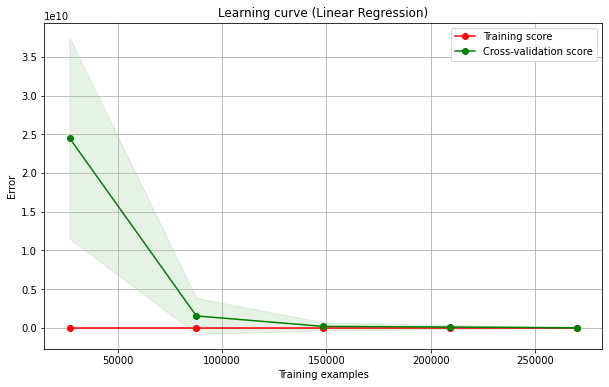

In [16]:
plot_learning_curve(LinearRegression(),title,train_encoded,
                    y,cv=10)
plt.show()

In [49]:
linregoh_preds=LinearRegression().fit(train_encoded,y).predict(test_encoded)
linregoh_preds = pd.DataFrame(linregoh_preds,index=test.index)
linregoh_preds.columns = ['target']
linregoh_preds.to_csv('predictions/linregoh.csv')

In [50]:
linregoh_preds

,target
id,
0,7.557617
5,7.872314
15,7.640625
16,7.511108
17,7.322144
...,...
499987,7.349976
499990,7.407959
499991,7.550659


Among these predictions, linear regression with one-hot categorical encoding performs the best, with a score of 0.86320. So, from this point, we will work with the one-hot encoded data. 

### Random Forest <a name = 'randomforest'>

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [14]:
rf = RandomForestRegressor(random_state=42)

rf_params = {'n_estimators' : [20,50,100]}
rf_grid = GridSearchCV(rf,rf_params, cv=5,n_jobs=-1)

rf_grid.fit(train_encoded,y)

d:\projects\funwithkaggle\venv\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [20, 50, 100]})

In [16]:
# best parameters
rf_grid.best_params_

{'n_estimators': 100}

In [18]:
rf = RandomForestRegressor(n_estimators=100,random_state=42)
rf.fit(train_encoded,y)
rf_preds = pd.DataFrame(rf.predict(test_encoded),index=test.index)
rf_preds.columns=['target']
rf_preds.to_csv('predictions/randomforest.csv')
rf_preds

<ipython-input-18-876ba32096b3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_encoded,y)


,target
id,
0,7.551556
5,8.097045
15,7.527492
16,7.039332
17,7.318058
...,...
499987,7.230251
499990,7.181622
499991,7.419960


Submitting this gives a score of 0.85814, which is an improvement. We continue with our tree-based models using gradient boosting. 

### XGBoost <a name='xgb'>

In [20]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [22]:
# get validation set for early stopping
X_train,X_val,y_train,y_val=train_test_split(train_encoded,y,train_size=0.9)

In [23]:
# fitting model
gbm = XGBRegressor(n_estimators=1000,learning_rate=0.01)
gbm.fit(X_train,y_train,early_stopping_rounds=5,
        eval_set=[(X_val,y_val)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
# making and saving prediction
gbm_preds = pd.DataFrame(gbm.predict(test_encoded),index=test.index,
                        columns=['target'])
gbm_preds.to_csv('predictions/gbm.csv')
gbm_preds

,target
id,
0,7.517580
5,7.820141
15,7.601399
16,7.422628
17,7.334715
...,...
499987,7.452847
499990,7.265567
499991,7.476901


Submitting this gives a score of 0.84695, which is an improvement, continuing to prove that gradient boosting machines are a powerhouse for these types of datasets. 

### What's next <a name='next'>
So far, we have tried a few models on the dataset, mostly one-hot encoded. We did not place much emphasis on hyperparameters tuning or feature selection. So, those are logical next steps. 